In [2]:
#import needed packages
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy.external as sce
import warnings
#import scvi
import h5py
import anndata as ad
import decoupler as dc

In [ ]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')
# Suppress FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)


In [3]:
#load harmony integrated data.
integrated_data_path = '../integrated_harmony_guzman.h5ad'

# Read the HDF5 file into a DataFrame
integrated_harmony = ad.read_h5ad(integrated_data_path)

Annotate data using big dataset of known markers:
To annotate single cell clusters, we can use cell type specific marker genes. These are genes that are mainly expressed exclusively by a specific cell type, making them useful to distinguish heterogeneous groups of cells. Marker genes were discovered and annotated in previous studies and there are some resources that collect and curate them.

Omnipath is one of the largest available databases of curated prior knowledge. Among its resources, there is PanglaoDB, a database of cell type markers, which can be easily accessed using a wrapper to Omnipath from decoupler.

In [4]:
markers = dc.get_resource('PanglaoDB')
markers

,genesymbol,canonical_marker,cell_type,germ_layer,human,human_sensitivity,human_specificity,mouse,mouse_sensitivity,mouse_specificity,ncbi_tax_id,organ,ubiquitiousness
0,CTRB1,False,Enterocytes,Endoderm,True,0.0,0.00439422,True,0.00331126,0.0204803,9606,GI tract,0.017
1,CTRB1,True,Acinar cells,Endoderm,True,1.0,0.000628931,True,0.957143,0.0159201,9606,Pancreas,0.017
2,KLK1,True,Endothelial cells,Mesoderm,True,0.0,0.00841969,True,0.0,0.0149153,9606,Vasculature,0.013
3,KLK1,False,Goblet cells,Endoderm,True,0.588235,0.00503937,True,0.903226,0.0124084,9606,GI tract,0.013
4,KLK1,False,Epithelial cells,Mesoderm,True,0.0,0.00823306,True,0.225806,0.0137585,9606,Epithelium,0.013
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8456,SLC14A1,True,Urothelial cells,Mesoderm,True,0.0,0.0181704,True,0.0,0.0,9606,Urinary bladder,0.008
8457,UPK3A,True,Urothelial cells,Mesoderm,True,0.0,0.0,True,0.0,0.0,9606,Urinary bladder,0.0
8458,UPK1A,True,Urothelial cells,Mesoderm,True,0.0,0.0,True,0.0,0.0,9606,Urinary bladder,0.0
8459,UPK2,True,Urothelial cells,Mesoderm,True,0.0,0.0,True,0.0,0.0,9606,Urinary bladder,0.0


In [5]:
mouse_markers = markers[(markers['mouse']=='True')&(markers['canonical_marker']=='True')&(markers['organ']=='Immune system')]

In [6]:
mouse_markers[mouse_markers['cell_type'].str.startswith('T')]['cell_type'].unique()

array(['T helper cells', 'T cells', 'T memory cells',
       'T regulatory cells', 'T follicular helper cells',
       'T cytotoxic cells'], dtype=object)

In [7]:
# Remove duplicated entries
mouse_markers = mouse_markers[~mouse_markers.duplicated(['cell_type', 'genesymbol'])]
mouse_markers['genesymbol_mouse'] = mouse_markers['genesymbol'].str.capitalize()

To infer functional enrichment scores we will run the Over Representation Analysis (ora) method. As input data it accepts an expression matrix (decoupler.run_ora) or the results of differential expression analysis (decoupler.get_ora_df). For the former, by default the top 5% of expressed genes by sample are selected as the set of interest (S), and for the latter a user-defined significance filtering can be used. Once we have S, it builds a contingency table using set operations for each set stored in the gene set resource being used (net). Using the contingency table, ora performs a one-sided Fisher exact test to test for significance of overlap between sets. The final score is obtained by log-transforming the obtained p-values, meaning that higher values are more significant.

In [8]:
dc.run_ora(
    mat=integrated_harmony,
    net=mouse_markers,
    source='cell_type',
    target='genesymbol_mouse',
    min_n=3,
    verbose=True
)

Running ora on mat with 49968 samples and 17278 targets for 23 sources.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 49968/49968 [00:45<00:00, 1095.93it/s]


In [9]:
acts = dc.get_acts(integrated_harmony, obsm_key='ora_estimate')

# We need to remove inf and set them to the maximum value observed for pvals=0
acts_v = acts.X.ravel()
max_e = np.nanmax(acts_v[np.isfinite(acts_v)])
acts.X[~np.isfinite(acts.X)] = max_e


In [10]:
df = dc.rank_sources_groups(acts, groupby='louvain', reference='rest', method='t-test_overestim_var')
df

,group,reference,names,statistic,meanchange,pvals,pvals_adj
0,0,rest,T cells,52.550919,3.708113,0.000000e+00,0.000000e+00
1,0,rest,T memory cells,19.453562,0.204068,4.022642e-83,7.116983e-83
2,0,rest,Nuocytes,15.550897,0.117528,4.944021e-54,7.580832e-54
3,0,rest,T helper cells,4.846775,0.057904,1.269915e-06,1.390859e-06
4,0,rest,Natural killer T cells,-3.312008,-0.035133,9.289907e-04,9.289907e-04
...,...,...,...,...,...,...,...
432,9,rest,Macrophages,-26.578440,-0.388420,3.697045e-139,1.417200e-138
433,9,rest,B cells naive,-36.628463,-5.037453,6.035315e-235,2.776245e-234
434,9,rest,B cells,-36.902050,-5.288206,9.097809e-237,5.231240e-236
435,9,rest,Plasma cells,-37.549720,-2.118716,6.616396e-244,5.072570e-243


In [13]:
n_ctypes = 3
ctypes_dict = df.groupby('group').head(n_ctypes).groupby('group')['names'].apply(lambda x: list(x)).to_dict()

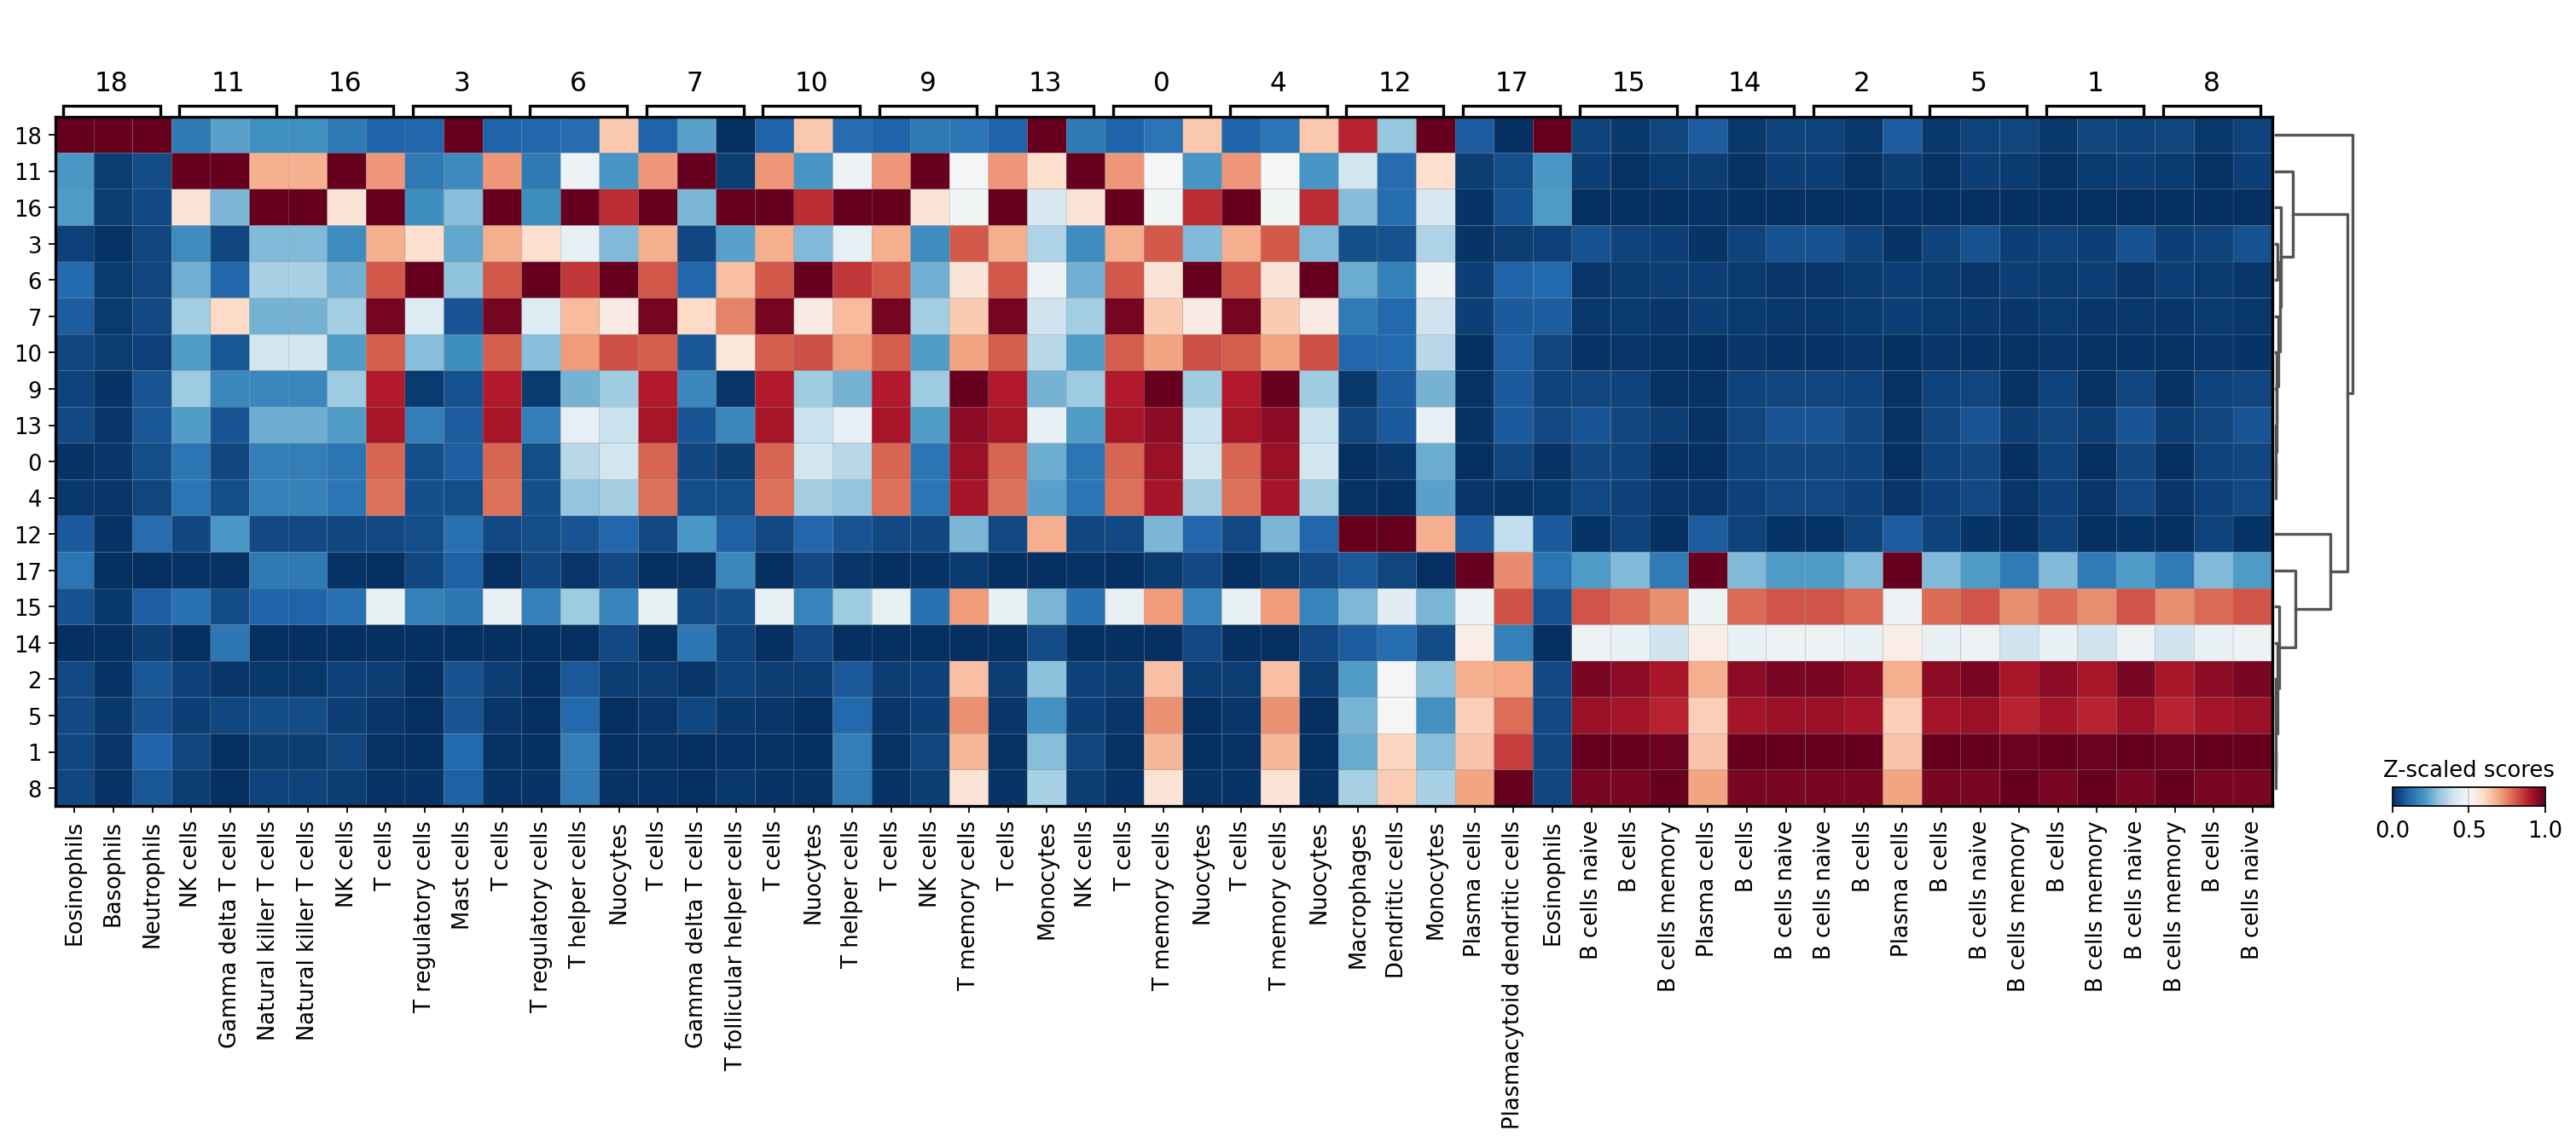

In [14]:
sc.pl.matrixplot(acts, ctypes_dict, 'louvain', dendrogram=True, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='RdBu_r')

In [7]:
#using the best aproxiimation name cell clusters.
integrated_harmony.obs["Cell_type_generic"]="B_cells"
integrated_harmony.obs.loc[integrated_harmony.obs['louvain'] == '0', 'Cell_type_generic'] = 'T_cells'
integrated_harmony.obs.loc[integrated_harmony.obs['louvain'] == '10', 'Cell_type_generic'] = 'T_cells'
integrated_harmony.obs.loc[integrated_harmony.obs['louvain'] == '11', 'Cell_type_generic'] = 'NK'
integrated_harmony.obs.loc[integrated_harmony.obs['louvain'] == '12', 'Cell_type_generic'] = 'Macrophages'
integrated_harmony.obs.loc[integrated_harmony.obs['louvain'] == '13', 'Cell_type_generic'] = 'T_cells'
integrated_harmony.obs.loc[integrated_harmony.obs['louvain'] == '14', 'Cell_type_generic'] = 'B_cells'
integrated_harmony.obs.loc[integrated_harmony.obs['louvain'] == '15', 'Cell_type_generic'] = 'B_cells'
integrated_harmony.obs.loc[integrated_harmony.obs['louvain'] == '16', 'Cell_type_generic'] = 'NK'
integrated_harmony.obs.loc[integrated_harmony.obs['louvain'] == '17', 'Cell_type_generic'] = 'Plasma_cells'
integrated_harmony.obs.loc[integrated_harmony.obs['louvain'] == '18', 'Cell_type_generic'] = 'Eosinophils'
integrated_harmony.obs.loc[integrated_harmony.obs['louvain'] == '2', 'Cell_type_generic'] = 'B_cells'
integrated_harmony.obs.loc[integrated_harmony.obs['louvain'] == '3', 'Cell_type_generic'] = 'Treg'
integrated_harmony.obs.loc[integrated_harmony.obs['louvain'] == '4', 'Cell_type_generic'] = 'T_cells'
integrated_harmony.obs.loc[integrated_harmony.obs['louvain'] == '6', 'Cell_type_generic'] = 'Treg'
integrated_harmony.obs.loc[integrated_harmony.obs['louvain'] == '7', 'Cell_type_generic'] = 'T_cells'
integrated_harmony.obs.loc[integrated_harmony.obs['louvain'] == '8', 'Cell_type_generic'] = 'B_memory'
integrated_harmony.obs.loc[integrated_harmony.obs['louvain'] == '9', 'Cell_type_generic'] = 'T_cells'
#acts.obs


In [5]:
#using the best aproxiimation name cell clusters.
integrated_harmony.obs["Cell type"]="B_cells"
integrated_harmony.obs.loc[integrated_harmony.obs['louvain'] == '0', 'Cell type'] = 'T_cells'
integrated_harmony.obs.loc[integrated_harmony.obs['louvain'] == '10', 'Cell type'] = 'T_cells'
integrated_harmony.obs.loc[integrated_harmony.obs['louvain'] == '11', 'Cell type'] = 'NK'
integrated_harmony.obs.loc[integrated_harmony.obs['louvain'] == '12', 'Cell type'] = 'Myeloid'
integrated_harmony.obs.loc[integrated_harmony.obs['louvain'] == '13', 'Cell type'] = 'T_cells'
integrated_harmony.obs.loc[integrated_harmony.obs['louvain'] == '14', 'Cell type'] = 'B_cells'
integrated_harmony.obs.loc[integrated_harmony.obs['louvain'] == '15', 'Cell type'] = 'B_cells'
integrated_harmony.obs.loc[integrated_harmony.obs['louvain'] == '16', 'Cell type'] = 'NK'
integrated_harmony.obs.loc[integrated_harmony.obs['louvain'] == '17', 'Cell type'] = 'Plasma_cells'
integrated_harmony.obs.loc[integrated_harmony.obs['louvain'] == '18', 'Cell type'] = 'Eosinophils'
integrated_harmony.obs.loc[integrated_harmony.obs['louvain'] == '2', 'Cell type'] = 'B_cells'
integrated_harmony.obs.loc[integrated_harmony.obs['louvain'] == '3', 'Cell type'] = 'Treg'
integrated_harmony.obs.loc[integrated_harmony.obs['louvain'] == '4', 'Cell type'] = 'T_cells'
integrated_harmony.obs.loc[integrated_harmony.obs['louvain'] == '6', 'Cell type'] = 'Treg'
integrated_harmony.obs.loc[integrated_harmony.obs['louvain'] == '7', 'Cell type'] = 'T_cells'
integrated_harmony.obs.loc[integrated_harmony.obs['louvain'] == '8', 'Cell type'] = 'B_memory'
integrated_harmony.obs.loc[integrated_harmony.obs['louvain'] == '9', 'Cell type'] = 'T_cells'
#acts.obs

In [11]:
integrated_harmony.obs['Cell_type_generic'].unique()

['B_cells', 'Treg', 'T_cells', 'NK', 'Macrophages', 'Eosinophils', 'B_memory', 'Plasma_cells']
Categories (8, object): ['B_cells', 'B_memory', 'Eosinophils', 'Macrophages', 'NK', 'Plasma_cells', 'T_cells', 'Treg']

In [16]:
#using the best aproxiimation name cell clusters.
integrated_harmony.obs["Cell_type_generic_2"]="B_cells_1"
integrated_harmony.obs.loc[integrated_harmony.obs['louvain'] == '0', 'Cell_type_generic_2'] = 'T_cells_1'
integrated_harmony.obs.loc[integrated_harmony.obs['louvain'] == '10', 'Cell_type_generic_2'] = 'T_cells_2'
integrated_harmony.obs.loc[integrated_harmony.obs['louvain'] == '11', 'Cell_type_generic_2'] = 'NK_1'
integrated_harmony.obs.loc[integrated_harmony.obs['louvain'] == '12', 'Cell_type_generic_2'] = 'Macrophages'
integrated_harmony.obs.loc[integrated_harmony.obs['louvain'] == '13', 'Cell_type_generic_2'] = 'T_cells_3'
integrated_harmony.obs.loc[integrated_harmony.obs['louvain'] == '14', 'Cell_type_generic_2'] = 'B_cell_ribo'
integrated_harmony.obs.loc[integrated_harmony.obs['louvain'] == '15', 'Cell_type_generic_2'] = 'B_cells_2'
integrated_harmony.obs.loc[integrated_harmony.obs['louvain'] == '16', 'Cell_type_generic_2'] = 'NK_2'
integrated_harmony.obs.loc[integrated_harmony.obs['louvain'] == '17', 'Cell_type_generic_2'] = 'Plasma_1'
integrated_harmony.obs.loc[integrated_harmony.obs['louvain'] == '18', 'Cell_type_generic_2'] = 'Eosinophils'
integrated_harmony.obs.loc[integrated_harmony.obs['louvain'] == '2', 'Cell_type_generic_2'] = 'B_cell_3'
integrated_harmony.obs.loc[integrated_harmony.obs['louvain'] == '3', 'Cell_type_generic_2'] = 'Treg_1'
integrated_harmony.obs.loc[integrated_harmony.obs['louvain'] == '4', 'Cell_type_generic_2'] = 'T_cells_4'
integrated_harmony.obs.loc[integrated_harmony.obs['louvain'] == '6', 'Cell_type_generic_2'] = 'Treg_2'
integrated_harmony.obs.loc[integrated_harmony.obs['louvain'] == '7', 'Cell_type_generic_2'] = 'T_cells_5'
integrated_harmony.obs.loc[integrated_harmony.obs['louvain'] == '8', 'Cell_type_generic_2'] = 'B_memory'
integrated_harmony.obs.loc[integrated_harmony.obs['louvain'] == '9', 'Cell_type_generic_2'] = 'T_cells_6'


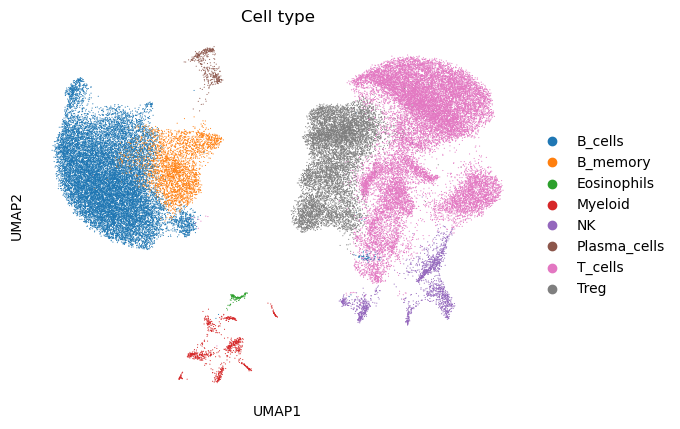

In [9]:
fig = sc.pl.umap(
    integrated_harmony, 
    color=['Cell type'], 
    legend_fontsize=None, 
    title=None, 
    color_map='viridis', 
    return_fig=True, 
    frameon=None
)

# Access the axes of the figure
ax = fig.axes[0]

# Remove the spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Optionally, remove the ticks
ax.set_xticks([])
ax.set_yticks([])

# Save the modified figure as a PDF
fig.savefig("UMAP_plot.pdf", bbox_inches='tight', format='pdf')

# Display the figure (optional)
plt.show()

/home/maa7095/miniconda3/envs/sc_python/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


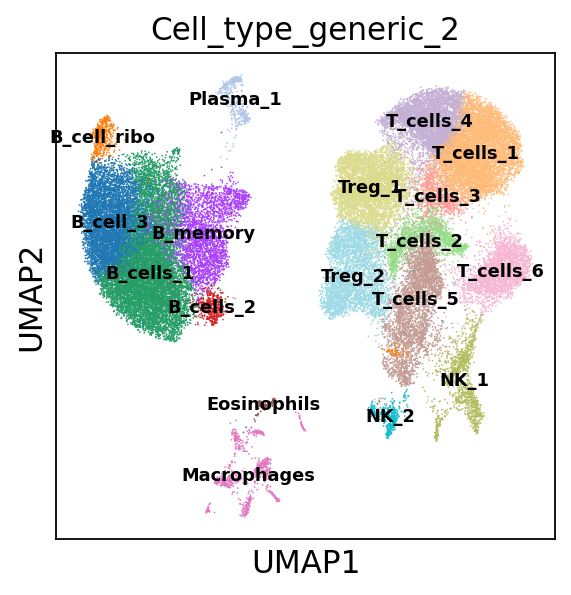

In [18]:
sc.pl.umap(integrated_harmony, color=['Cell_type_generic_2'], cmap='RdBu_r', legend_loc='on data', legend_fontsize=8)

/home/maa7095/miniconda3/envs/sc_python/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


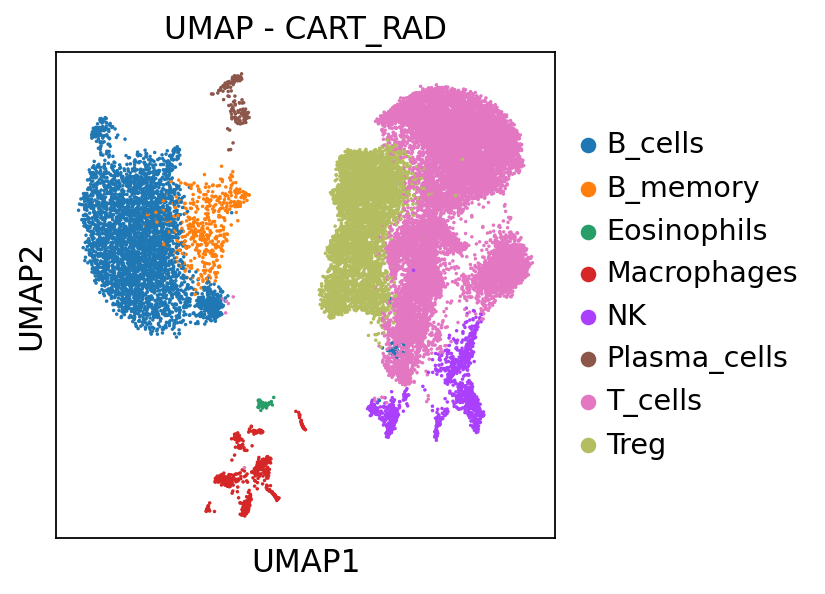

/home/maa7095/miniconda3/envs/sc_python/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


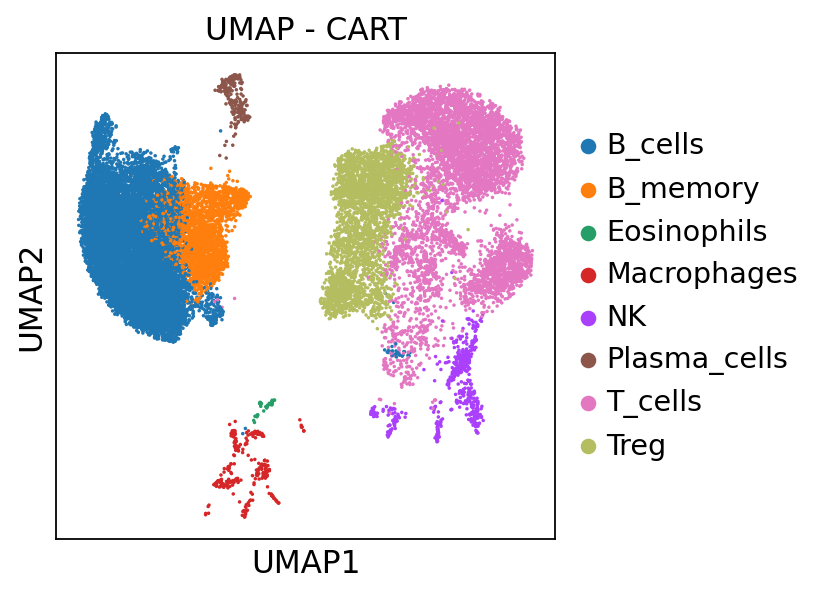

In [6]:
#two plots per conditon
for condition in integrated_harmony.obs['Condition'].unique():
    # Subset the data for the current sample
    subset_data = integrated_harmony[integrated_harmony.obs['Condition'] == condition, :]
    # Plot UMAP with color based on batch
    sc.pl.umap(subset_data, color='Cell type', title=f'UMAP - {condition}', size=10)

In [17]:
def plot_violin_qc_per_cluster(adata,annotation,qc_col):
    data_fm=pd.DataFrame()
    for clusters in adata.obs[annotation].unique():
        subset_data=adata[adata.obs[annotation]==clusters].copy()
        number_genes = subset_data.obs[[qc_col,annotation]]
        data_fm=pd.concat([data_fm,number_genes], ignore_index=True)
    plt.figure(figsize=(10, 6))
    vio_genes=sns.violinplot(x=annotation, y=qc_col, data=data_fm, palette='Set1')
    vio_genes.set_xticklabels(vio_genes.get_xticklabels(), rotation=45, ha='right')
    plt.title(f'Violin Plot of {qc_col} for Each Cluster')
    plt.show()

/tmp/ipykernel_1815108/1884870187.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  vio_genes.set_xticklabels(vio_genes.get_xticklabels(), rotation=45, ha='right')


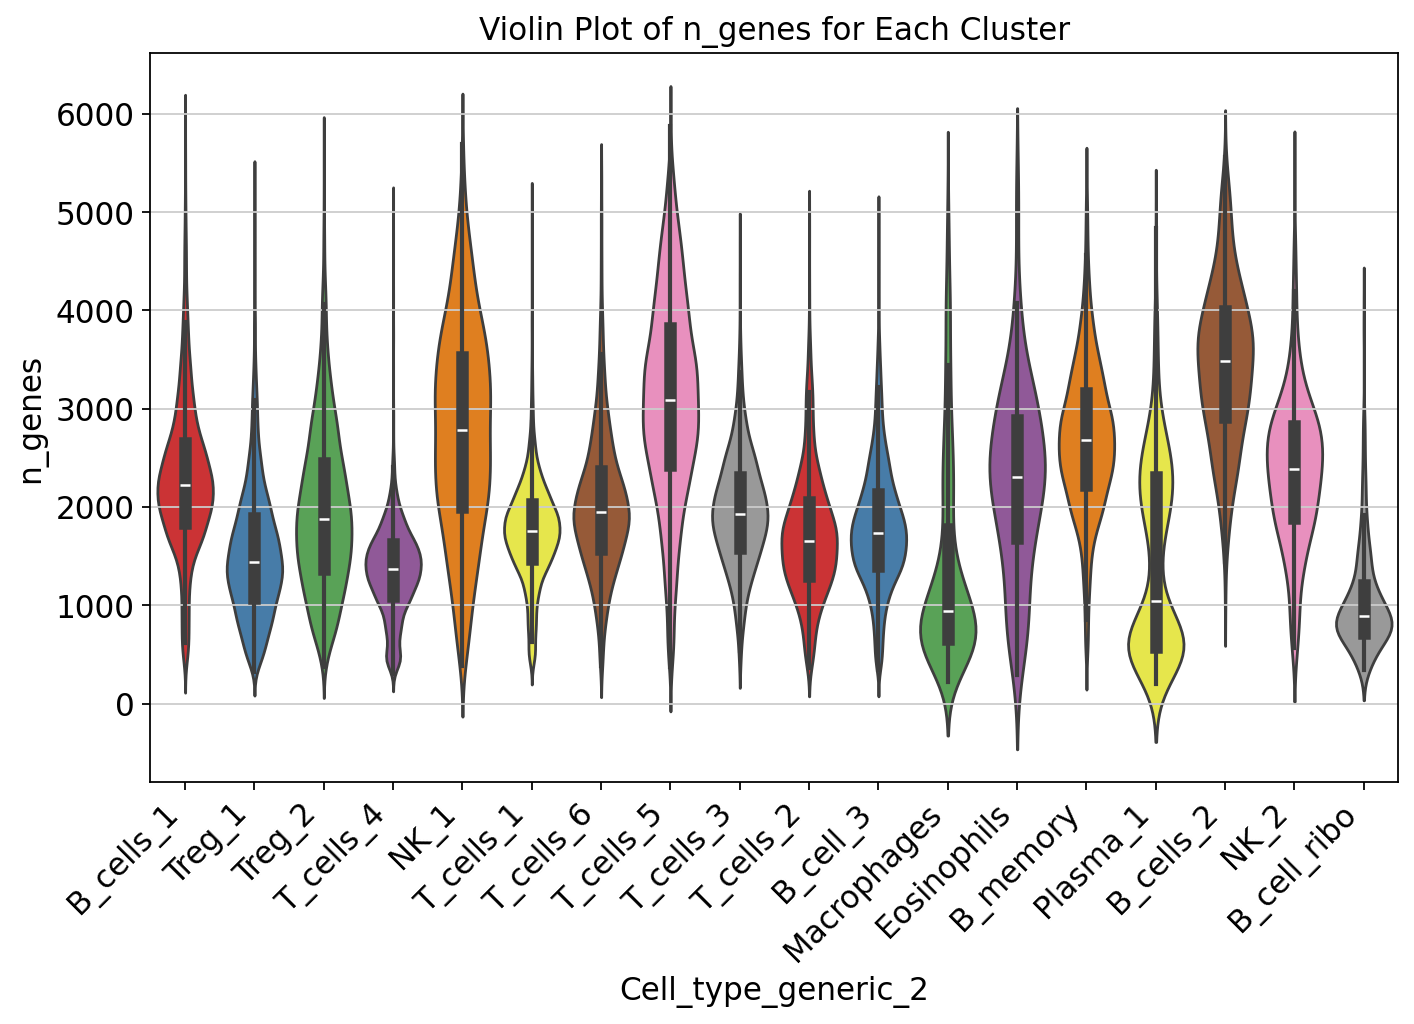

In [18]:
plot_violin_qc_per_cluster(integrated_harmony,'Cell_type_generic_2','n_genes')

/tmp/ipykernel_1815108/1884870187.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  vio_genes.set_xticklabels(vio_genes.get_xticklabels(), rotation=45, ha='right')


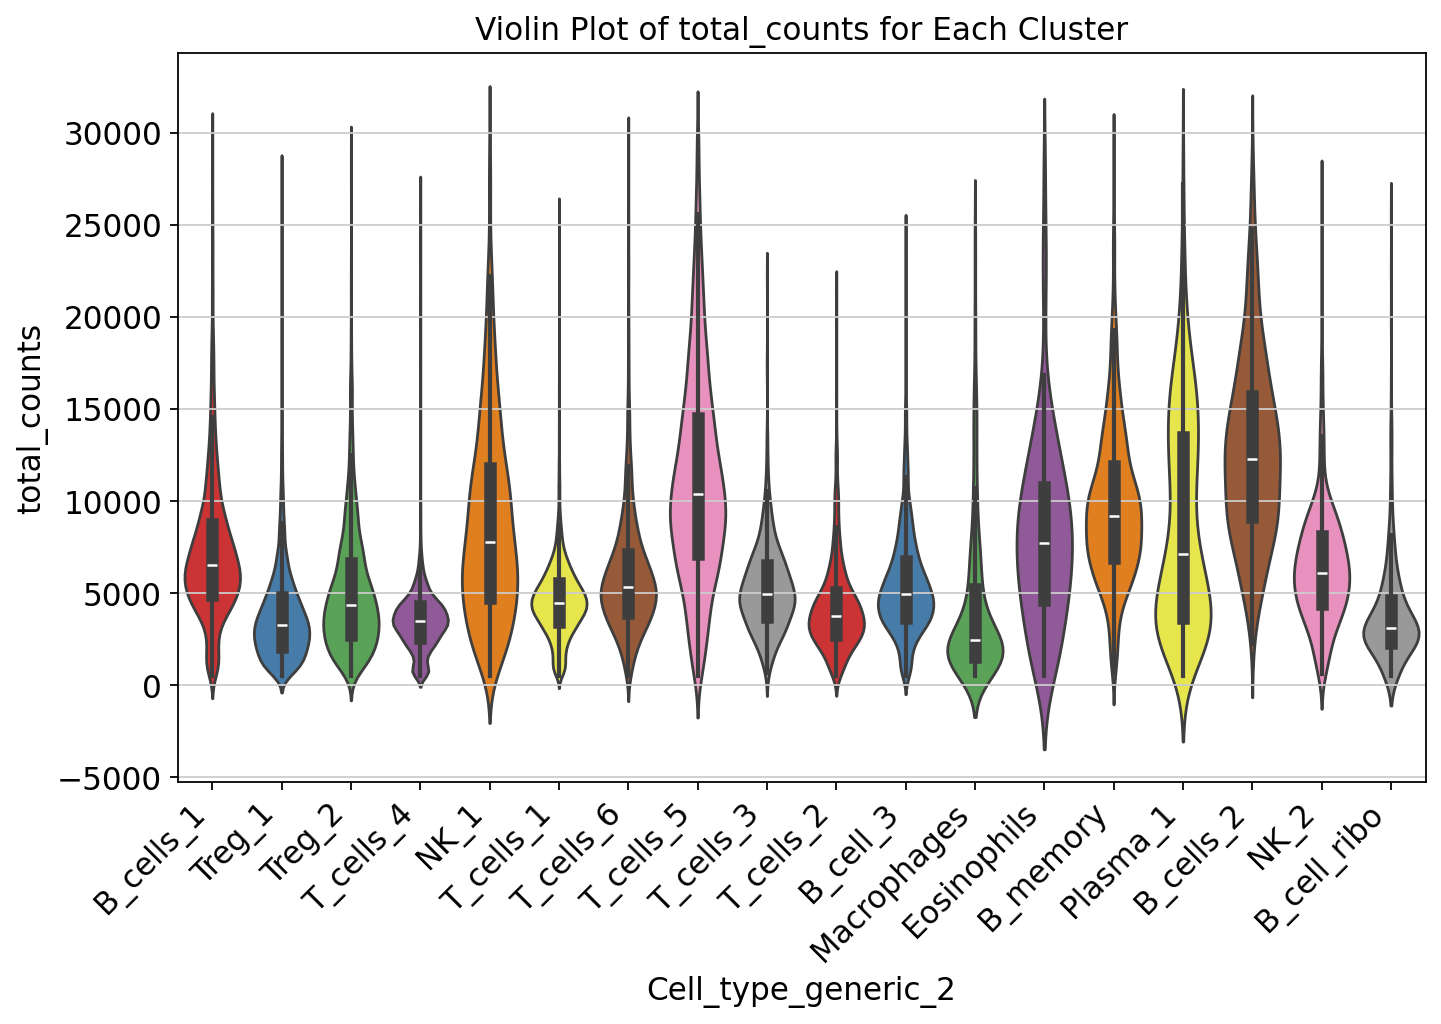

In [19]:
plot_violin_qc_per_cluster(integrated_harmony,'Cell_type_generic_2','total_counts')

/tmp/ipykernel_1815108/1884870187.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  vio_genes.set_xticklabels(vio_genes.get_xticklabels(), rotation=45, ha='right')


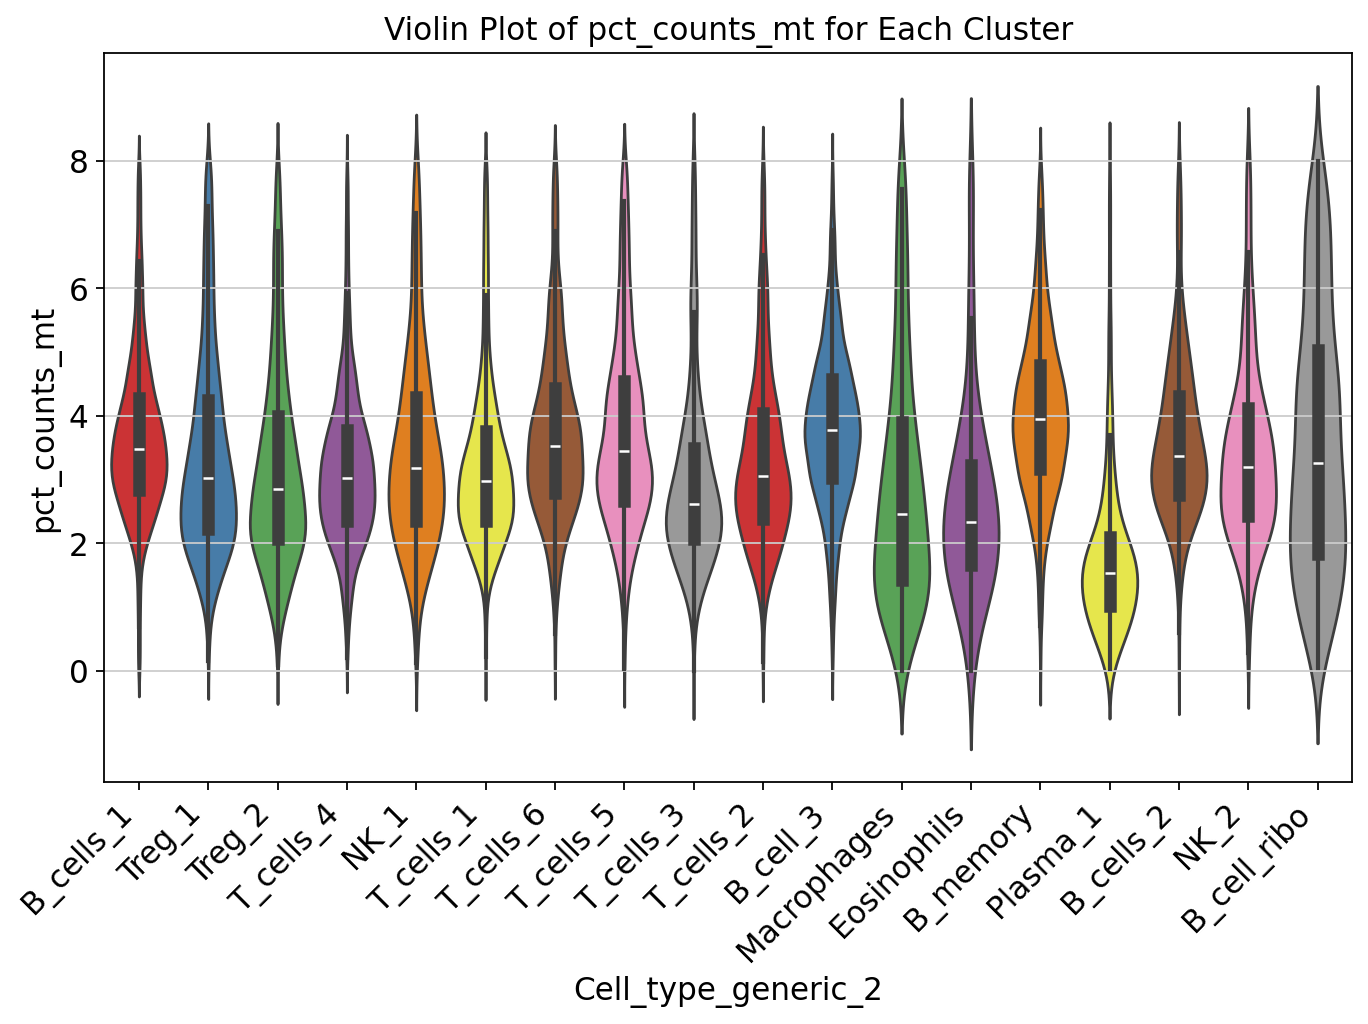

In [20]:
plot_violin_qc_per_cluster(integrated_harmony,'Cell_type_generic_2','pct_counts_mt')

In [47]:
# save object
harmony_int_annot = 'harmony_integrated_annotated.h5ad'
#integrated_harmony.write(harmony_int_annot)

In [3]:
#load harmony integrated data.
harmony_int_annot = '../harmony_integrated_annotated.h5ad'

# Read the HDF5 file into a DataFrame
integrated_harmony = ad.read_h5ad(harmony_int_annot)

In [41]:
# Initialize an empty dictionary to store the marker genes for each cluster
sc.tl.rank_genes_groups(integrated_harmony, groupby="Cell type",  method='wilcoxon', key_added='cell_type_generic')
df_markers_harmony = sc.get.rank_genes_groups_df(adata=integrated_harmony, group=None,key='cell_type_generic')


ranking genes
    finished: added to `.uns['cell_type_generic']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:42)


In [44]:
top_markers=pd.DataFrame(integrated_harmony.uns['cell_type_generic']['names']).head(5)

#plot top markers obtained by DE analysis between the different groups.
marker = {}

# Iterate over the columns of the DataFrame
for cluster in top_markers.columns:
    # Convert the cluster to a string
    cluster_str = str(cluster)
    # Extract the genes for the current cluster
    genes = top_markers[cluster].dropna().tolist()
    # Add the genes for the current cluster to the dictionary
    marker[cluster_str] = genes

marker

{'B_cells': ['Mef2c', 'Bank1', 'Cd74', 'Ebf1', 'H2-Aa'],
 'B_memory': ['Ighm', 'Cacna1e', 'Plac8', 'Mzb1', 'Tcf4'],
 'Eosinophils': ['Hdc', 'Fcer1g', 'Gab2', 'Ier3', 'Anxa1'],
 'Myeloid': ['Cst3', 'Ftl1', 'Atox1', 'Tyrobp', 'Tmsb4x'],
 'NK': ['Chn2', 'Id2', 'Il2rb', 'Ccl5', 'AW112010'],
 'Plasma_cells': ['Jchain', 'Ighm', 'Txndc5', 'Igkc', 'Ly6c2'],
 'T_cells': ['Lef1', 'Ms4a4b', 'Themis', 'Skap1', 'Gm2682'],
 'Treg': ['Ikzf2', 'Ctla4', 'Tox', 'Il2ra', 'Rabgap1l']}

/home/maa7095/miniconda3/envs/sc_python/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


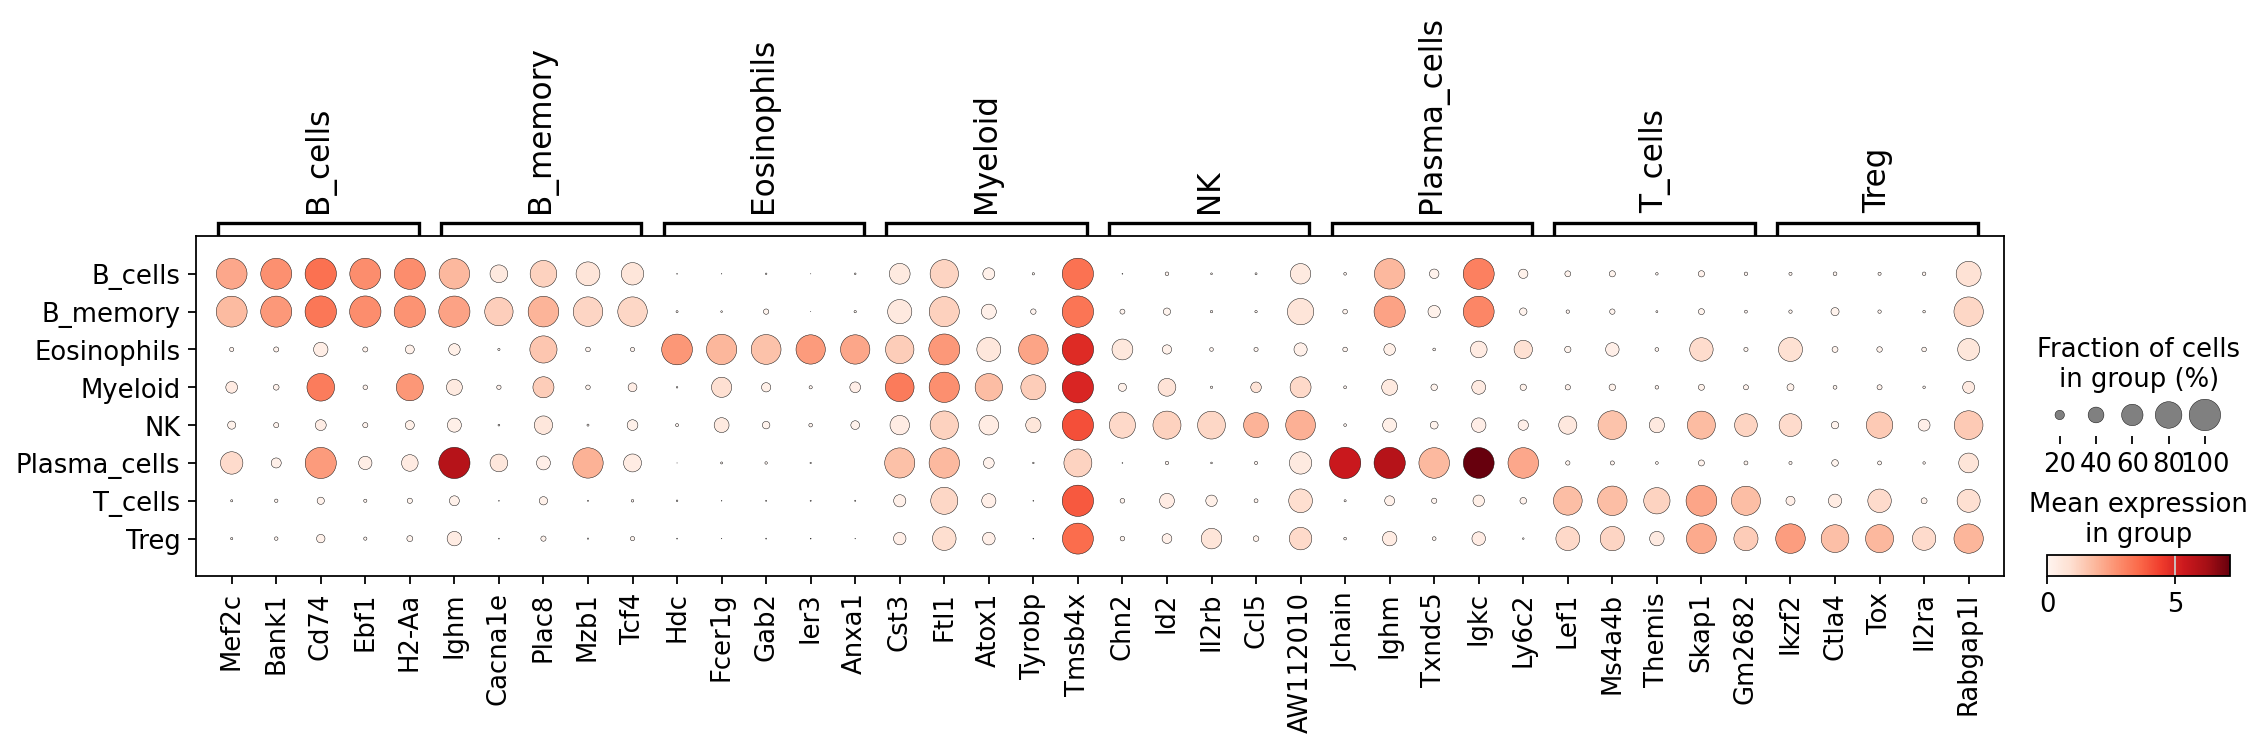

In [45]:
sc.pl.dotplot(integrated_harmony, marker, groupby='Cell type', save="top_markers_cell_generic.pdf")

/home/maa7095/miniconda3/envs/sc_python/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


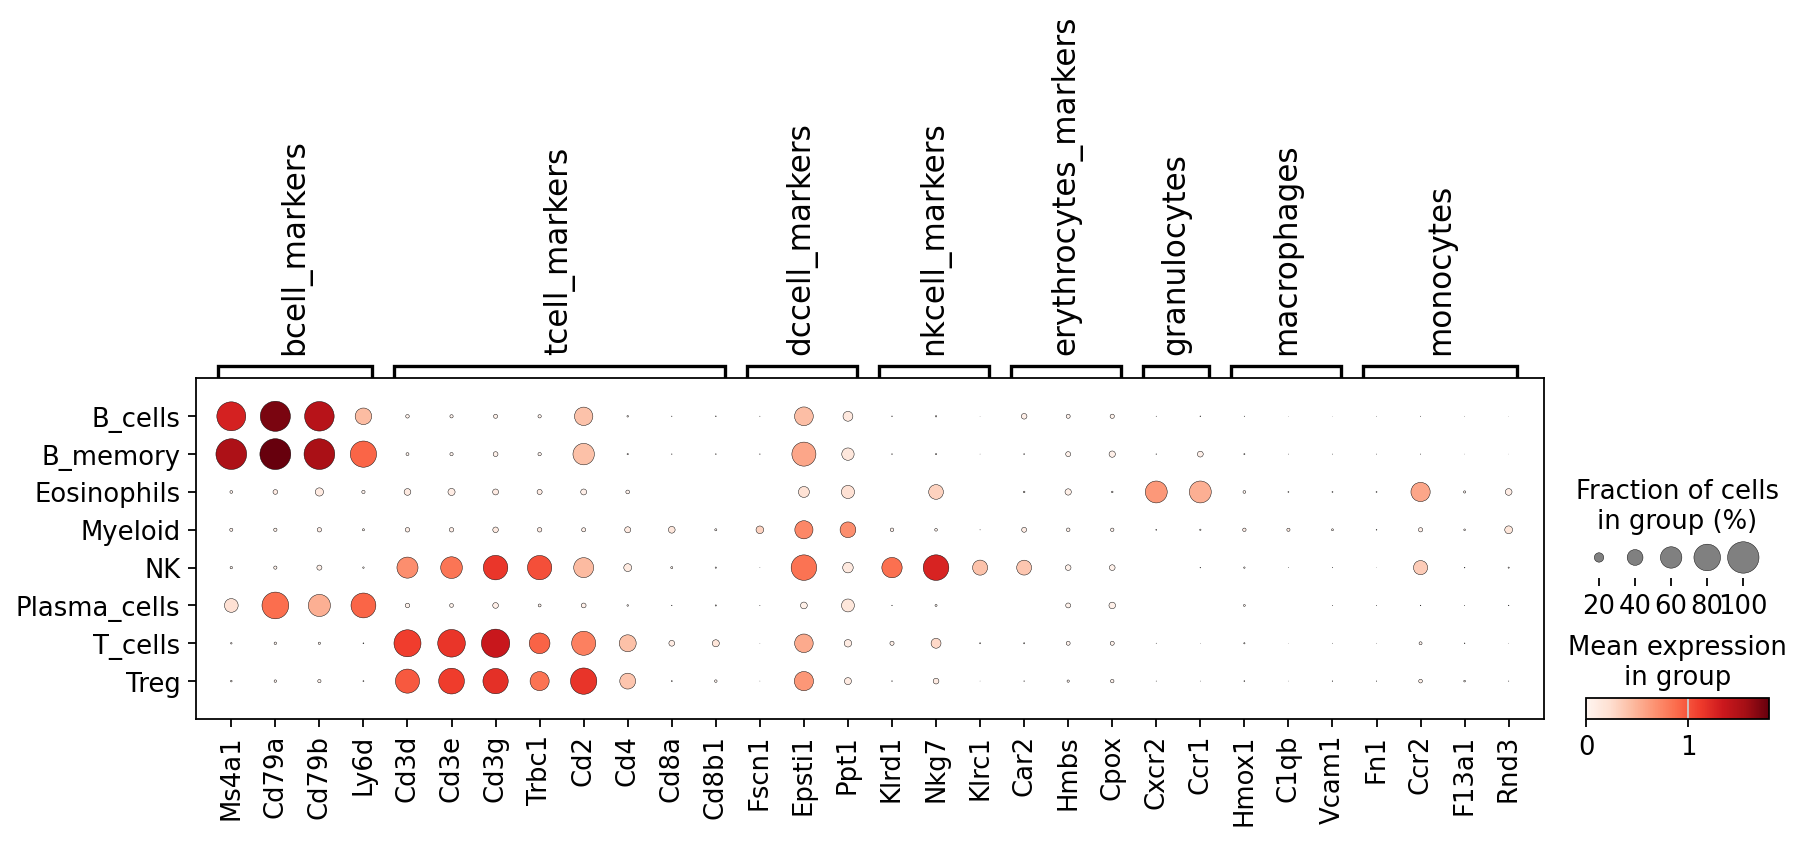

In [46]:
#i need to create a new column with cell_type identification. And then run this violoin plot
known_markers={'bcell_markers': ['Ms4a1', 'Cd79a', 'Cd79b', 'Ly6d'],'tcell_markers' : ['Cd3d', 'Cd3e', 'Cd3g', 'Trbc1', 'Cd2', 'Cd4', 'Cd8a', 'Cd8b1'], 'dccell_markers': ['Fscn1', 'Epsti1', 'Ppt1'],'nkcell_markers': ['Klrd1', 'Nkg7', 'Klrc1'],'erythrocytes_markers': ['Car2', 'Hmbs', 'Cpox'],'granulocytes' : ['Cxcr2',  'Ccr1'], 'macrophages' : ['Hmox1', 'C1qb', 'Vcam1'],'monocytes' : ['Fn1', 'Ccr2', 'F13a1', 'Rnd3']}

new_known_markers={'Dentritic':['Cd83','Xcr1'], 'Macrophages':['Cd86', 'Cd80'], "Tcells": [ 'Cd4'], 'NK': ['Klrd1', 'Nkg7'], 'Bcells':['Cd19', 'Cd27']}

sc.pl.dotplot(integrated_harmony, known_markers, groupby='Cell type')
#sc.pl.dotplot(integrated_harmony, new_known_markers, groupby='Cell_type_generic')
                                                                                                                                                                                                                                                                                              

In [43]:
integrated_harmony.obs.Cell_type_generic.unique()

['B_cells', 'Treg', 'T_cells', 'NK', 'B_naive', 'Macrophages', 'Eosinophils', 'B_memory', 'Plasma', 'B_cell_ribo']
Categories (10, object): ['B_cell_ribo', 'B_cells', 'B_memory', 'B_naive', ..., 'NK', 'Plasma', 'T_cells', 'Treg']

In [28]:
#same bcells to recluster them in a new analysis
b_cell_types = ['B_cells', 'B_memory', 'Plasma'] 
b_cell_data = integrated_harmony[integrated_harmony.obs['Cell_type_generic'].isin(b_cell_types)]
# save object
b_cell_data_save = 'b_cell_analysis/b_cell_data.h5ad'
#b_cell_data.write(b_cell_data_save)

In [45]:
#same bcells to recluster them in a new analysis
macrophages_data = integrated_harmony[integrated_harmony.obs['Cell_type_generic']=='Macrophages'].copy()
# save object
macrophages_data_save = 'macrophages_data/mecrophages_data.h5ad'
#macrophages_data.write(macrophages_data_save)